# Volumetric heat maps

In [1]:
samples = 10
widths = range(1, 29)

In [2]:
import os
import math
import numpy as np
import random
import time
from pyqrack import QrackSimulator

In [3]:
os.environ['QRACK_QUNITMULTI_DEVICES']='1'
os.environ['QRACK_QPAGER_DEVICES']='1'
os.environ['QRACK_QPAGER_DEVICES_HOST_POINTER']='0'
os.environ['QRACK_MAX_ALLOC_MB']='147456,15872'
os.environ['QRACK_MAX_PAGING_QB']='30'
os.environ['QRACK_MAX_CPU_QB']='34'

In [4]:
def mcx(circ, c, q):
    circ.mcx([c], q)

def mcy(circ, c, q):
    circ.mcy([c], q)

def mcz(circ, c, q):
    circ.mcz([c], q)

def macx(circ, c, q):
    circ.macx([c], q)

def macy(circ, c, q):
    circ.macy([c], q)

def macz(circ, c, q):
    circ.macz([c], q)

def rand_u3(circ, q):
    th = random.uniform(0, 4 * math.pi)
    ph = random.uniform(0, 4 * math.pi)
    lm = random.uniform(0, 4 * math.pi)
    circ.u(q, th, ph, lm)

def generate_circuits(width):
    gateSequence = [ 0, 3, 2, 1, 2, 1, 0, 3 ]
    two_qubit_gates = mcx, mcy, mcz, macx, macy, macz

    # Nearest-neighbor couplers:
    row_len = math.ceil(math.sqrt(width))

    time_results = [0 for _ in range(width)]
    
    qsim = QrackSimulator(width)

    for t in range(samples):
        qsim.reset_all()
        d_time_results = []
        start = time.perf_counter()
        
        for i in range(width):
            # Single bit gates
            for j in range(width):
                rand_u3(qsim, j)
            
            # Nearest-neighbor couplers:
            ############################
            # gate = gateSequence.pop(0)
            # gateSequence.append(gate)
            # for row in range(1, row_len, 2):
            #     for col in range(row_len):
            #         temp_row = row
            #         temp_col = col
            #         temp_row = temp_row + (1 if (gate & 2) else -1);
            #         temp_col = temp_col + (1 if (gate & 1) else 0)
            #
            #         if (temp_row < 0) or (temp_col < 0) or (temp_row >= row_len) or (temp_col >= row_len):
            #             continue
            #
            #         b1 = row * row_len + col
            #         b2 = temp_row * row_len + temp_col
            #
            #         if (b1 >= width) or (b2 >= width):
            #             continue
            #
            #         choice = random.choice(two_qubit_gates)
            #         choice(qsim, b1, b2)

            # Fully-connected couplers:
            ###########################
            unused_bits = list(range(width))
            while len(unused_bits) > 1:
                b1 = random.choice(unused_bits)
                unused_bits.remove(b1)
                b2 = random.choice(unused_bits)
                unused_bits.remove(b2)
            
                # Two bit gates
                choice = random.choice(two_qubit_gates)
                choice(qsim, b1, b2)

            d_time_results.append(time.perf_counter() - start)

        for i in range(width):
            time_results[i] += d_time_results[i] / samples

    return time_results

In [5]:
qrack_time_results = {}
for i in widths:
    print("Width: ", i)
    qrack_time_results[i] = generate_circuits(i)

Width:  1
Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
Width:  2
Width:  3
Width:  4
Width:  5
Width:  6
Width:  7
Width:  8
Width:  9
Width:  10
Width:  11
Width:  12
Width:  13
Width:  14
Width:  15
Width:  16
Width:  17
Width:  18
Width:  19
Width:  20
Width:  21
Width:  22
Width:  23
Width:  24
Width:  25
Width:  26
Width:  27
Width:  28


In [6]:
print(qrack_time_results)

{1: [5.247200078883906e-06], 2: [1.9938800141972022e-05, 7.432319998770253e-05], 3: [1.2960399908479305e-05, 6.832579983893084e-05, 9.82869998551905e-05], 4: [2.0622100055334162e-05, 0.00011555420005606721, 0.00020489720000114173, 0.0003040314000827493], 5: [2.3628800045116803e-05, 0.00012666490001720377, 0.0002075076000437548, 0.00030050290015424256, 0.00038332920003085745], 6: [3.0462500035355333e-05, 0.00017509090012026717, 0.00030178619990692826, 0.00044259549995331334, 0.0005796331998681126, 0.0007056718000058027], 7: [3.2011700113798724e-05, 0.00018658560002222656, 0.00038159540008564363, 0.0005349297999600822, 0.0006769156999325787, 0.0008161675000337708, 0.0009579675000168209], 8: [4.011829996670713e-05, 0.00023322749984799884, 0.00042190819995084904, 0.0006274152000514732, 0.0008424709998507752, 0.0010534947999985887, 0.0012634292999791797, 0.0014712705997226294], 9: [4.115499987165094e-05, 0.00023359639990303552, 0.0005193492000216792, 0.0008023578000575071, 0.001072090799789

## Results

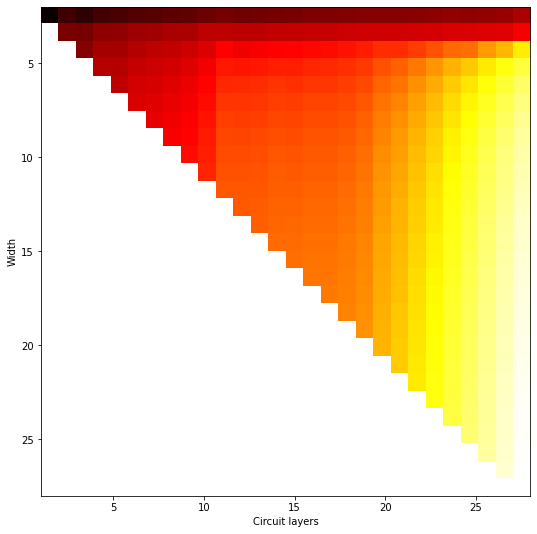

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 9))
# plt.title("Fidelity vs. layer depth, 54 qubits, A100 GPU")
plt.xlabel("Circuit layers")
plt.ylabel("Width")

left = 1
right = 28
bottom = 28
top = 2
extent = [left, right, bottom, top]

h = {}
for key in qrack_time_results:
    h[key] = np.log(qrack_time_results[key]).tolist()
    h[key] = h[key] + (28 - key) * [0]
h = pd.DataFrame(h)
mask = np.tri(28, k=-1)
h = np.ma.array(h, mask=mask)

plt.imshow(h, cmap='hot', interpolation='nearest', extent=extent, aspect=1.038461538)

fig.savefig('heat_map_time.png', dpi=100)

In [8]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#43~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Apr 21 16:51:08 UTC 2
Linux-5.19.0-42-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-42-generic', version='#43~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Apr 21 16:51:08 UTC 2', machine='x86_64')
Linux
x86_64


In [9]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [10]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'